In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from ipywidgets import interact
import matplotlib.patches as matpatch
from descartes.patch import PolygonPatch
from shapely.ops import cascaded_union, polygonize
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
from scipy.integrate import quad, dblquad
from scipy import interpolate
import shapely.geometry as sg
import descartes
#import sobol_seq
from matplotlib import rcParams
rcParams['axes.titlepad'] = 10
from randomgen import RandomGenerator, MT19937, Xoroshiro128, PCG64, ThreeFry, DSFMT, Philox
%matplotlib notebook

# Алгоритм Монте-Карло для нахождения площади сложной фигуры

<img src="dextar.jpg">

https://cyberleninka.ru/article/n/analiz-rabochey-oblasti-robota-dextar-dexterous-twin-arm-robot

### Робот DexTar
Робот состоит из четырёх штанг постоянной длинны и известно расстояние между основаниями штанг

Задача: найти площадь рабочей области робота и нарисовать её

$$ D_1 = \Big( 2 \Big( -\frac{x_p + d/2}{y_p}\Big)\Big(\frac{(x_p + d/2)^2}{2 y_p} + \frac{y_p}{2} + \frac{a^2-b^2}{2 y_p}\Big)\Big)^2-4\Big(1+\frac{(x_p+d/2)^2}{y_p^2}\Big)\cdot \bigg(\Big(\frac{(x_p+d/2)^2}{2 y_p}+\frac{y_p}{2} + \frac{a^2-b^2}{2  y_p}\Big)^2-a^2\bigg)$$

$$ D_2 = \Big( 2 \Big( -\frac{x_p - d/2}{y_p}\Big)\Big(\frac{(x_p - d/2)^2}{2 y_p} + \frac{y_p}{2} + \frac{a^2-b^2}{2 y_p}\Big)\Big)^2-4\Big(1+\frac{(x_p-d/2)^2}{y_p^2}\Big)\cdot \bigg(\Big(\frac{(x_p-d/2)^2}{2 y_p}+\frac{y_p}{2} + \frac{a^2-b^2}{2  y_p}\Big)^2-a^2\bigg)$$

In [2]:
def check_D_1(x, y, a, b, d):#проверяем лежит ли точка вне малой окр-ти 
    """
    Check point if it is outside lower limit of leg (what is the same if these points outside the smallest circles)
    
    Parameters
    ----------
    x, y : float, the coordinates of points
    x0, y0 : float, the coordinates of the circle's center
    r : float, radius of the circle
    Returns
    -------
    Boolean massive of all points which are outside the smallest circles
    
    """
    return (((2*(-(x + d/2)/(y))*((x + d/2)**2/(2*y) + y/2 + (a**2 - b**2)/(2*y)))**2 - 
            4*(1 + ((x + d/2)**2)/(y**2))*((((x + d/2)**2)/(2*y) + y/2 + (a**2 - b**2)/(2*y))**2-a**2)) >= 0)

In [3]:
def check_D_2(x, y, a, b, d):#проверяем лежит ли точка вне малой окр-ти
    """
    Check points if it is inside the higher limit of leg (what is the same if these points inside the biggest circles)
    
    Parameters
    ----------
    x, y : float, the coordinates of points
    x0, y0 : float, the coordinates of the circle's center
    r : float, radius of the circle
    Returns
    -------
    Boolean massive of all points which are inside the biggest circles
    
    return ((x - x0)**2 + (y - y0)**2 <= r**2)
    
    """
    return (((2*(-(x - d/2)/(y))*(((x - d/2)**2)/(2*y) + y/2 + (a**2 - b**2)/(2*y)))**2 - 
            4*(1 + ((x - d/2)**2)/(y**2))*((((x - d/2)**2)/(2*y) + y/2 + (a**2 - b**2)/(2*y))**2-a**2)) >= 0)

### Алгоритм Монте-Карло
1) Ограничим нашу рабочую область прямоугольником с известными сторонами

2) Заполним прямоугольник случайным образом $N$-точками

3) Площадь искомой области будет вычисляться по формуле: $S=\dfrac{(b-a)\cdot (c-d) \cdot  K}{N}$, где $a$ и $b$ - левая и правая границы интегрирования, $с$ и $d$ - верхняя и нижняя границы интегрирования, $K$ - кол-во точек, которые попали в искомую область

In [6]:
%load_ext cython

In [7]:
%%cython -a --compile-args=-O3
cimport cython
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

cdef double c_check(double[:] x, double[:] y, double a, double b, double d, long p) nogil:
    cdef Py_ssize_t i
    cdef double c = 0
    for i in range(0, p):
        if (((2*(-(x[i] + d/2)/(y[i]))*((x[i] + d/2)**2/(2*y[i]) + y[i]/2 + (a*a - b*b)/(2*y[i])))**2 - 
            4*(1 + ((x[i] + d/2)**2)/(y[i]**2))*((((x[i] + d/2)**2)/(2*y[i]) + y[i]/2 + (a*a - b*b)/(2*y[i]))**2-a*a)) >= 0) and (
            ((2*(-(x[i] - d/2)/(y[i]))*(((x[i] - d/2)**2)/(2*y[i]) + y[i]/2 + (a**2 - b**2)/(2*y[i])))**2 - 
            4*(1 + ((x[i] - d/2)**2)/(y[i]**2))*((((x[i] - d/2)**2)/(2*y[i]) + y[i]/2 + (a*a - b*b)/(2*y[i]))**2-a*a)) >= 0):
            c+=1
    return c

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def c_monte_carlo(double a, double b, double d, long p, double[:] x, double[:] y):
    cdef double Yh = a+b+d
    cdef double Xl = -(a+b+d)
    cdef double Xh = a+b+d
    cdef double Yl = -(a+b+d)
    cdef double c = 0
    cdef Py_ssize_t i
    c = c_check(x, y, a, b, d, p)
    cdef double area = ((Xh-Xl)*(Yh-Yl)*c/p)
    return  area

In [8]:
def uniform_grid(a, b, d, p, seed=1234):
    """ 
    Compute the area of DexTar's workspace with Monte Carlo method using uniform grid
    
    Parameters
    ----------
    l1_l, l2_l : float, the lowest limit of legs
    l1_h, l2_h : float, the highest limit of legs
    d : float, length between legs of the robot
    p : int, amount of points
    seed : int, seed for rng, default = 1234
    Returns
    -------
    area: float , area of 2-RPR robot's workspace
    Xl, Xh : float, X-axis limits for MC rectangle
    Yl, Yh : float, Y-axis limits for MC rectangle
    
    """
    Xl = -(a+b+d)
    Xh = a+b+d
    Yl = -(a+b+d)
    Yh = a+b+d
    X1 = np.linspace(Xl, Xh, int(np.sqrt(p)))
    Y1 = np.linspace(Yl, Yh, int(np.sqrt(p)))
    X, Y = np.meshgrid(X1, Y1)
    X = X.ravel()
    Y = Y.ravel()
    #print('Стандартное отклоченние',np.std(X), np.std(Y))
    #print('Мат.ожидание',np.mean(X), np.mean(Y))
    c = 0
    c = sum((check_D_1(X, Y, a, b, d)) &  (check_D_2(X, Y, a, b, d)))
    area = ((Xh-Xl)*(Yh-Yl)*c/p)
    return area, X[check_D_1(X, Y, a, b, d) & check_D_2(X, Y, a, b, d)], Y[check_D_1(X, Y, a, b, d) & check_D_2(X, Y, a, b, d)] , X, Y

In [9]:
def random123(a, b, d, p, seed=1234):
    """ 
    Compute the area of DexTar's workspace with Monte Carlo method using ThreeFry RNG
    
    Parameters
    ----------
    a : float, the lowest limit of legs
    b : float, the highest limit of legs
    d : float, length between legs of the robot
    p : int, amount of points
    seed : int, seed for rng, default = 1234
    Returns
    -------
    area: float , area of 2-RPR robot's workspace
    Xl, Xh : float, X-axis limits for MC rectangle
    Yl, Yh : float, Y-axis limits for MC rectangle
    
    """
    prng = RandomGenerator(ThreeFry(seed=int(seed)))
    Xl = -(a+b+d)
    Xh = a+b+d
    Yl = -(a+b+d)
    Yh = a+b+d
    X = prng.uniform(Xl, Xh, size=int(p))
    Y = prng.uniform(Yl, Yh, size=int(p))
    #print('Стандартное отклоченние',np.std(X), np.std(Y))
    #print('Мат.ожидание',np.mean(X), np.mean(Y))
    c = 0
    c = sum((check_D_1(X, Y, a, b, d)) &  (check_D_2(X, Y, a, b, d)))
    area = ((Xh-Xl)*(Yh-Yl)*c/p)
    rect1=Rectangle([-(a+b+d), -(a+b+d)], 2*(a+b+d), 2*(a+b+d), fill=False, color='g', linewidth=2.0)
    return area, X[check_D_1(X, Y, a, b, d) & check_D_2(X, Y, a, b, d)], Y[check_D_1(X, Y, a, b, d) & check_D_2(X, Y, a, b, d)] , X, Y

In [10]:
def pcg_64(a, b, d, p, seed=1234):
    """ 
    Compute the area of DexTar's workspace with Monte Carlo method using PCG64 RNG
    
    Parameters
    ----------
    a : float, the lowest limit of legs
    b : float, the highest limit of legs
    d : float, length between legs of the robot
    p : int, amount of points
    seed : int, seed for rng, default = 1234
    Returns
    -------
    area: float , area of 2-RPR robot's workspace
    Xl, Xh : float, X-axis limits for MC rectangle
    Yl, Yh : float, Y-axis limits for MC rectangle
    
    """
    prng = RandomGenerator(PCG64(seed=int(seed)))
    Xl = -(a+b+d)
    Xh = a+b+d
    Yl = -(a+b+d)
    Yh = a+b+d
    X = prng.uniform(Xl, Xh, size=int(p))
    Y = prng.uniform(Yl, Yh, size=int(p))
    #print('Стандартное отклоченние',np.std(X), np.std(Y))
    #print('Мат.ожидание',np.mean(X), np.mean(Y))
    c = 0
    c = sum((check_D_1(X, Y, a, b, d)) &  (check_D_2(X, Y, a, b, d)))
    area = ((Xh-Xl)*(Yh-Yl)*c/p)
    rect1=Rectangle([-(a+b+d), -(a+b+d)], 2*(a+b+d), 2*(a+b+d), fill=False, color='g', linewidth=2.0)
    return area, X[check_D_1(X, Y, a, b, d) & check_D_2(X, Y, a, b, d)], Y[check_D_1(X, Y, a, b, d) & check_D_2(X, Y, a, b, d)] , X, Y

In [11]:
def mt_rng(a, b, d, p, seed=1234):
    """ 
    Compute the area of DexTar's workspace with Monte Carlo method using Xoroshiro128 RNG
    
    Parameters
    ----------
    a : float, the lowest limit of legs
    b : float, the highest limit of legs
    d : float, length between legs of the robot
    p : int, amount of points
    seed : int, seed for rng, default = 1234
    Returns
    -------
    area: float , area of 2-RPR robot's workspace
    Xl, Xh : float, X-axis limits for MC rectangle
    Yl, Yh : float, Y-axis limits for MC rectangle
    
    """
    prng = RandomGenerator(Xoroshiro128(seed=int(seed)))
    Xl = -(a+b+d)
    Xh = a+b+d
    Yl = -(a+b+d)
    Yh = a+b+d
    X = prng.uniform(Xl, Xh, size=int(p))
    Y = prng.uniform(Yl, Yh, size=int(p))
    #print('Стандартное отклоченние',np.std(X), np.std(Y))
    #print('Мат.ожидание',np.mean(X), np.mean(Y))
    c = 0
    c = sum((check_D_1(X, Y, a, b, d)) &  (check_D_2(X, Y, a, b, d)))
    area = ((Xh-Xl)*(Yh-Yl)*c/p)
    rect1=Rectangle([-(a+b+d), -(a+b+d)], 2*(a+b+d), 2*(a+b+d), fill=False, color='g', linewidth=2.0)
    return area, X[check_D_1(X, Y, a, b, d) & check_D_2(X, Y, a, b, d)], Y[check_D_1(X, Y, a, b, d) & check_D_2(X, Y, a, b, d)] , X, Y

In [12]:
def Monte_Carlo(a, b, d, p, seed=1234):
    """ 
    Compute the area of 2-RPR robot's workspace with Monte Carlo method usint MT19937(default numpy random generator)
    
    Parameters
    ----------
    l1_l, l2_l : float, the lowest limit of legs
    l1_h, l2_h : float, the highest limit of legs
    d : float, length between legs of the robot
    p : int, amount of points
    seed : int, seed for rng, default = 1234
    Returns
    -------
    area: float , area of 2-RPR robot's workspace
    Xl, Xh : float, X-axis limits for MC rectangle
    Yl, Yh : float, Y-axis limits for MC rectangle
    
    """
    prng = np.random.RandomState(int(seed))
    Xl = -(a+b+d)
    Xh = a+b+d
    Yl = -(a+b+d)
    Yh = a+b+d
    X = prng.uniform(Xl, Xh, size=int(p))
    Y = prng.uniform(Yl, Yh, size=int(p))
    #print('Стандартное отклоченние',np.std(X), np.std(Y))
    #print('Мат.ожидание',np.mean(X), np.mean(Y))
    c = 0
    c = sum((check_D_1(X, Y, a, b, d)) &  (check_D_2(X, Y, a, b, d)))
    area = ((Xh-Xl)*(Yh-Yl)*c/p)
    return area, X[check_D_1(X, Y, a, b, d) & check_D_2(X, Y, a, b, d)], Y[check_D_1(X, Y, a, b, d) & check_D_2(X, Y, a, b, d)] , X, Y

In [13]:
def mas_gen(a, b, d, p, name, seed=1234):
    """ 
    Generate 2 P-size arrays for MC with chosen RNG 
    
    """
    prng = RandomGenerator(name(seed=int(seed)))
    X = prng.uniform(a+b+d, -(a+b+d), size=int(p))
    Y = prng.uniform(a+b+d, -(a+b+d), size=int(p))
    return X, Y

In [38]:
a = 72
b = 87
d = 60
p = 25000

In [15]:
%timeit c_check(mas_gen(a, b, d, p, MT19937)[0], mas_gen(a, b, d, p, MT19937)[1], a, b, d, p)

NameError: name 'c_check' is not defined

### Comparation time of work of different RNG using Cython and Python

#### MT19937

In [16]:
%timeit c_monte_carlo(a, b, d, p, mas_gen(a, b, d, p, MT19937)[0], mas_gen(a, b, d, p, MT19937)[1])

6.94 ms ± 18.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%timeit Monte_Carlo(a, b, d, p)

47.9 ms ± 247 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
c_monte_carlo(a, b, d, p, mas_gen(a, b, d, p, MT19937)[0], mas_gen(a, b, d, p, MT19937)[1])

58497.07248

In [40]:
Monte_Carlo(a, b, d, p)[0]

58497.07248

#### Uniform grid

In [20]:
X1 = np.linspace(-(a+b+d), a+b+d, int(np.sqrt(p)))
Y1 = np.linspace(-(a+b+d), a+b+d, int(np.sqrt(p)))
X, Y = np.meshgrid(X1, Y1)
X = X.ravel()
Y = Y.ravel()
%timeit c_monte_carlo(a, b, d, p, X, Y)

5.47 ms ± 32.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%timeit uniform_grid(72,87,60,25000)

47.9 ms ± 785 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Xoroshiro128

In [22]:
%timeit c_monte_carlo(a, b, d, p, mas_gen(a, b, d, p, Xoroshiro128)[0], mas_gen(a, b, d, p, Xoroshiro128)[1])

6.58 ms ± 95.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%timeit mt_rng(a, b, d, p)

51 ms ± 541 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### PCG64

In [24]:
%timeit c_monte_carlo(a, b, d, p, mas_gen(a, b, d, p, PCG64)[0], mas_gen(a, b, d, p, PCG64)[1])

7.39 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
%timeit pcg_64(a, b, d, p)

50.4 ms ± 3.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### ThreeFry

In [26]:
%timeit c_monte_carlo(a, b, d, p, mas_gen(a, b, d, p, ThreeFry)[0], mas_gen(a, b, d, p, ThreeFry)[1])

7.39 ms ± 68.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
%timeit random123(a, b, d, p)

49.4 ms ± 684 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Philox

In [28]:
%timeit c_monte_carlo(a, b, d, p, mas_gen(a, b, d, p, DSFMT)[0], mas_gen(a, b, d, p, DSFMT)[1])

6.62 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### DSFMT

In [29]:
%timeit c_monte_carlo(a, b, d, p, mas_gen(a, b, d, p, DSFMT)[0], mas_gen(a, b, d, p, DSFMT)[1])

6.59 ms ± 75.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
def dextar_workspace(a, b, d, p):
    area, X, Y, X1, Y1 = Monte_Carlo(a , b , d , p)
    area_uni, X_uni, Y_uni, X1_uni, Y1_uni = uniform_grid(a , b , d , p)
    area_horo = mt_rng(a, b, d, p)[0]
    #print('Площадь через алгоритм Монте-Карло =', area)
    #print('Площадь через равномерную сетку =', area_uni)
    #print('Площадь через алгоритм Монте-Карло с генератором Хороширо =', area_horo)
    fig, ax = plt.subplots(2,1,figsize=(10, 10))
    #ax[0].set_ylim(-(a+b+d), a+b+d)
    #ax[0].set_xlim(-(a+b+d), a+b+d)
    ax[0].scatter(X,Y)
    rect1=Rectangle([-(a+b+d), -(a+b+d)], 2*(a+b+d), 2*(a+b+d), fill=False, color='g', linewidth=2.0)
    ax[0].add_patch(rect1)
    ax[0].grid()
    ax[0].set_aspect('equal')
    #ax[1].set_ylim(-(a+b+d), a+b+d)
    #ax[1].set_xlim(-(a+b+d), a+b+d)
    ax[1].scatter(X_uni, Y_uni)
    ax[1].grid()
    ax[1].set_aspect('equal')

<IPython.core.display.Javascript object>


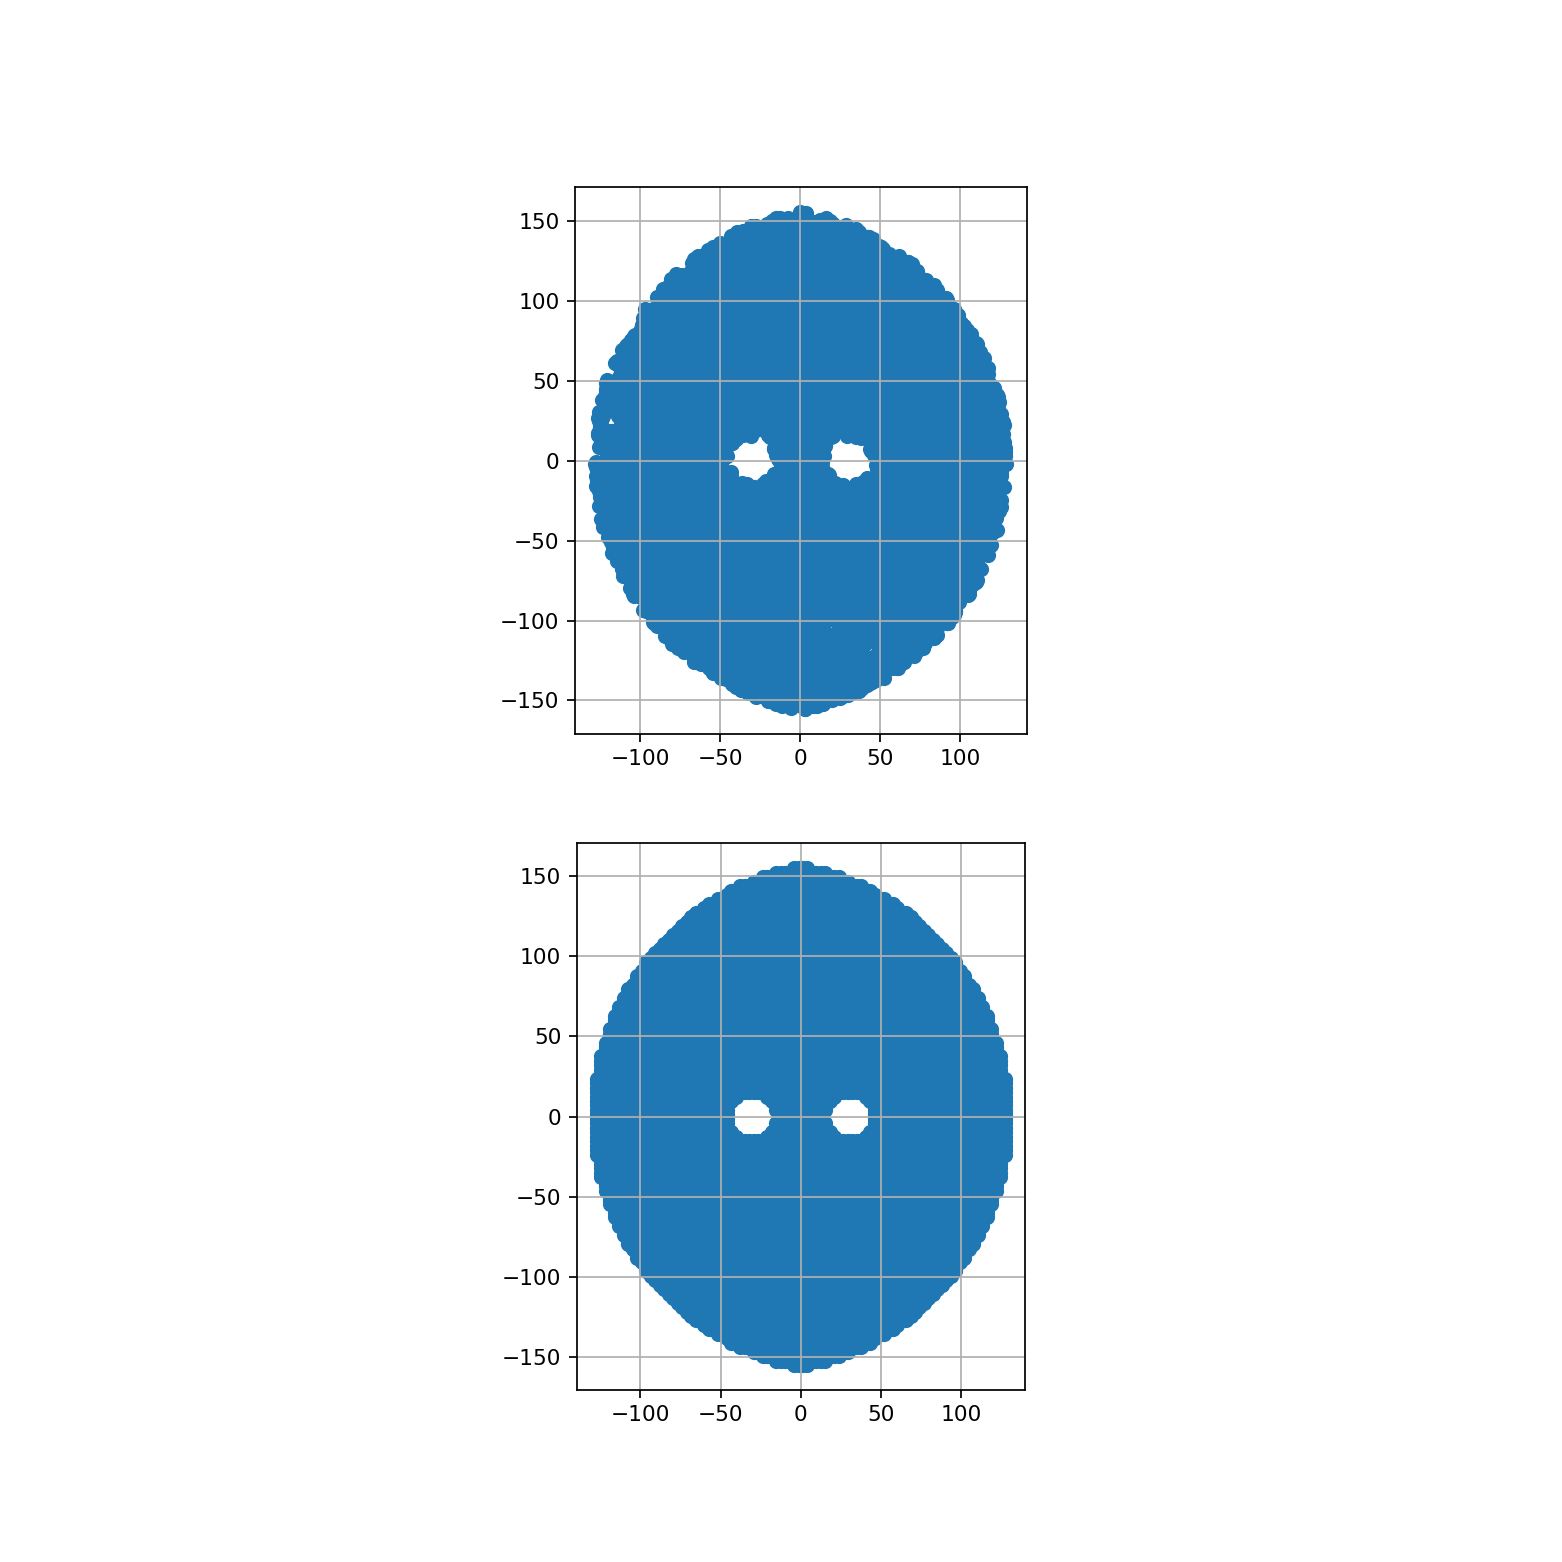

In [58]:
dextar_workspace(a ,b, d, p)

In [32]:
names = [MT19937, PCG64, Xoroshiro128, ThreeFry, DSFMT, Philox]

In [42]:
xx = np.logspace(4.0, 6.0, num=50)
result = np.zeros((len(names), 50))
for i in range(len(names)):
    result[i] = [c_monte_carlo( a, b, d, p, mas_gen(a, b, d, p, names[i])[0], mas_gen(a, b, d, p, names[i])[1]) for p in xx]

In [43]:
xx1 = np.linspace(1, 1000, num=100)
result1 = np.zeros((len(names), 100))
for i in range(len(names)):
    result1[i] = [c_monte_carlo( a, b, d, p, mas_gen(a, b, d, 100000, names[i], seed)[0], mas_gen(a, b, d, 100000, names[i], seed)[1]) for seed in xx1]

### Mean values and standard deviations for different seed for used RNG (a = 72 b = 87 d = 60 p = 100000 seed=(1,1000))

In [44]:
for i in range(len(names)):
    print("%50s: mean %5d +- %.7g" % (names[i], np.mean(result1[i]), np.std(result1[i])))

               <class 'randomgen.mt19937.MT19937'>: mean 58980 +- 574.8891
                   <class 'randomgen.pcg64.PCG64'>: mean 59086 +- 550.324
     <class 'randomgen.xoroshiro128.Xoroshiro128'>: mean 59135 +- 571.4439
             <class 'randomgen.threefry.ThreeFry'>: mean 59058 +- 605.6551
                   <class 'randomgen.dsfmt.DSFMT'>: mean 59018 +- 528.4224
                 <class 'randomgen.philox.Philox'>: mean 59035 +- 546.7183


### Area's dependences on count of point with mentioned RNG (a = 72 b = 87 d = 60, p = (1e4, 1e6) seed = 1234)

<IPython.core.display.Javascript object>


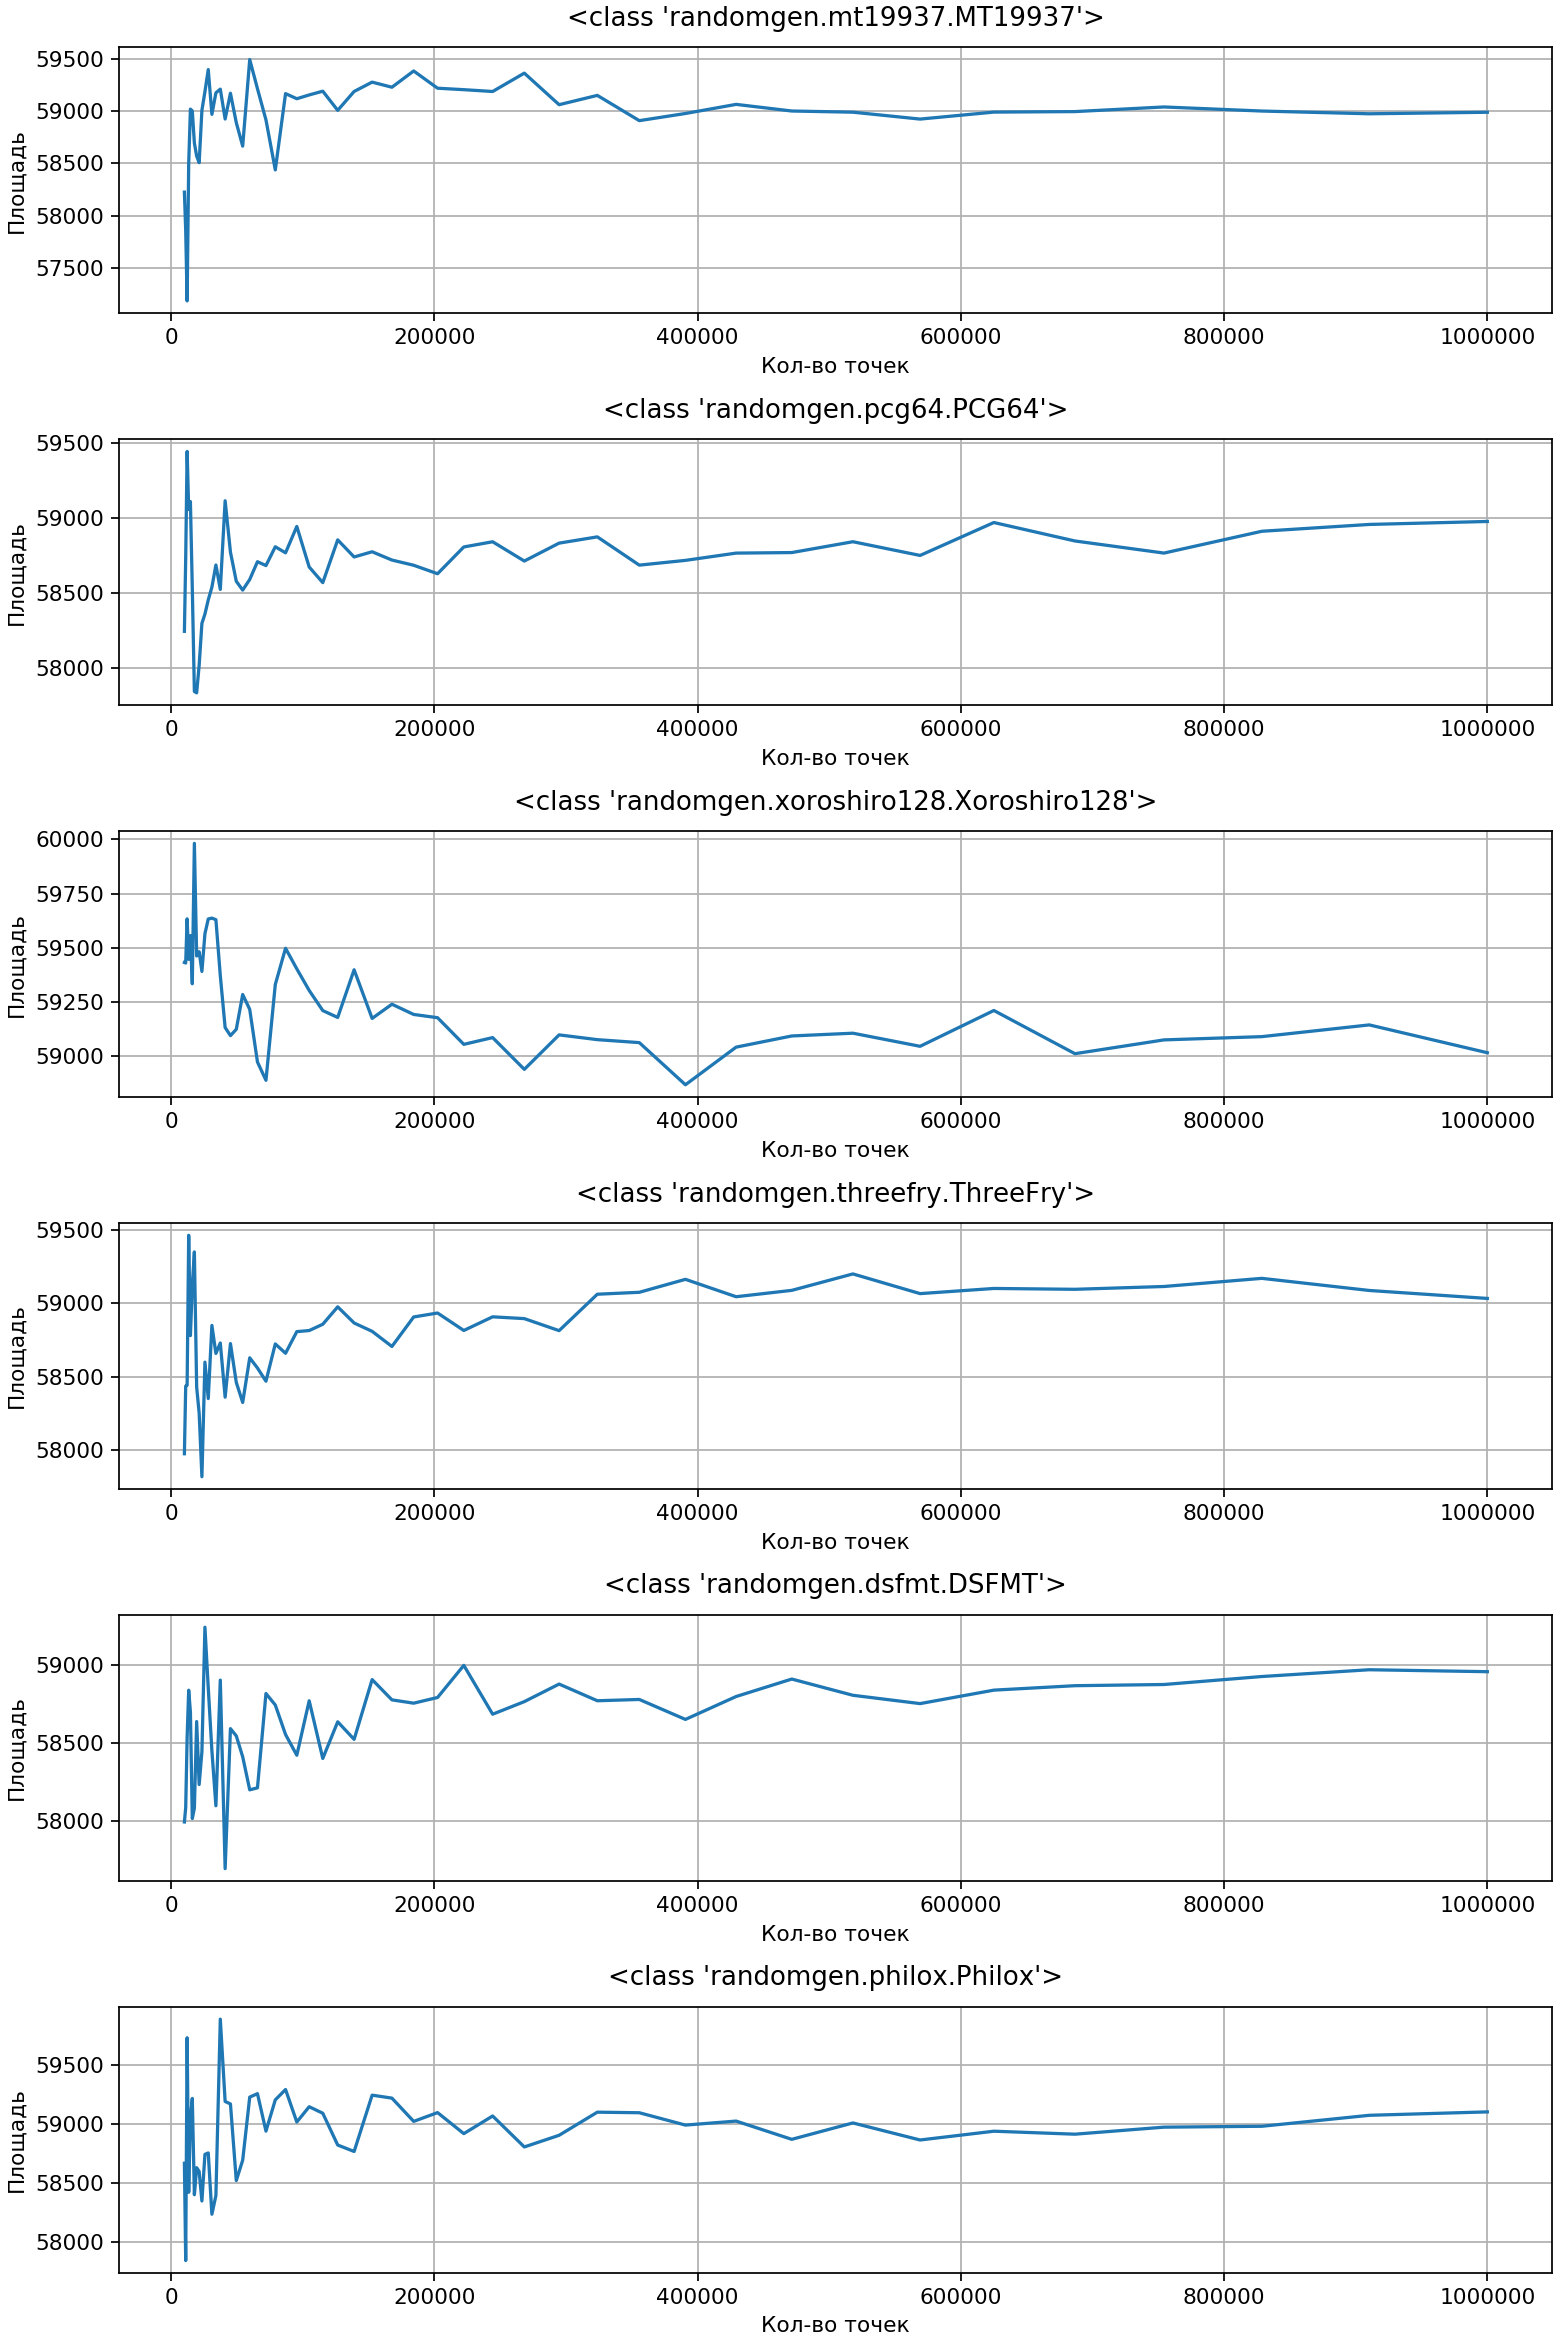

In [56]:
fig, ax = plt.subplots(len(names), 1, figsize=(10, 15), constrained_layout=True)
#fig.suptitle('Зависимости значений площадей от кол-ва точек при ралзичных RNG', fontsize=16)
for i in range(len(names)):
    ax[i].set_title(str(names[i]))
    ax[i].set_ylabel('Площадь')
    ax[i].set_xlabel('Кол-во точек')
    ax[i].plot(xx, result[i])
    ax[i].grid()


<IPython.core.display.Javascript object>


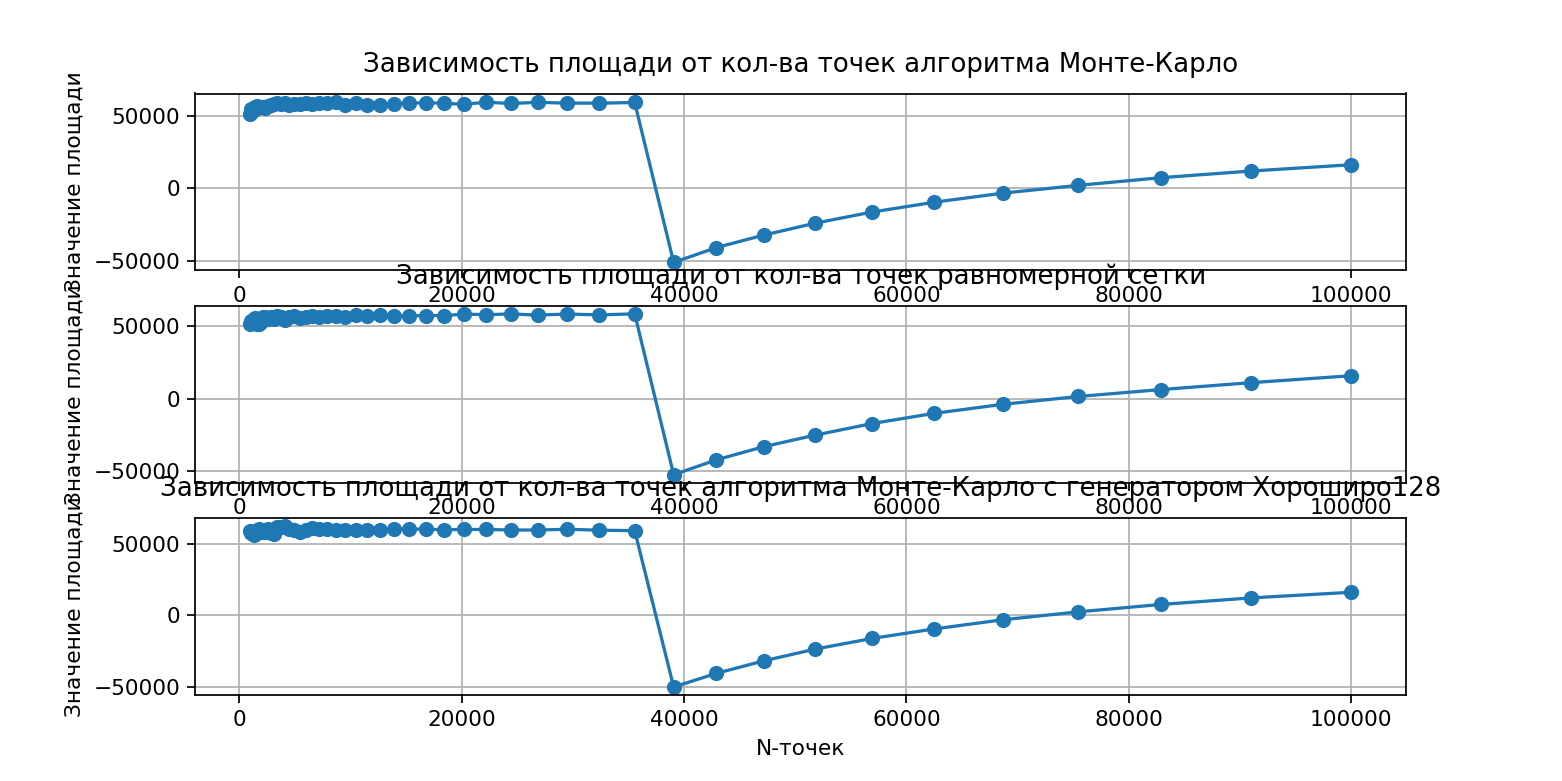

D:\Programms\Anaconda\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in long_scalars
D:\Programms\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
D:\Programms\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in add
  from ipykernel import kernelapp as app
D:\Programms\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
D:\Programms\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in add
  app.launch_new_instance()
D:\Programms\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
D:\Programms\Anaconda\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in 

In [12]:
xx = np.logspace(3.0, 5.0, num=50)
fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(10, 5))

ax1.plot(xx, [Monte_Carlo(72,87,60,p)[0] for p in xx],'o-')
ax1.set_title('Зависимость площади от кол-ва точек алгоритма Монте-Карло')
ax1.set_xlabel('N-точек')
ax1.set_ylabel('Значение площади')
ax1.grid()
ax2.plot(xx, [uniform_grid(72,87,60,p)[0] for p in xx],'o-')
ax2.set_title('Зависимость площади от кол-ва точек равномерной сетки')
ax2.set_xlabel('N-точек')
ax2.set_ylabel('Значение площади')
ax2.grid()
ax3.plot(xx, [mt_rng(72,87,60,p)[0] for p in xx],'o-')
ax3.set_title('Зависимость площади от кол-ва точек алгоритма Монте-Карло с генератором Хороширо128')
ax3.set_xlabel('N-точек')
ax3.set_ylabel('Значение площади')
ax3.grid()

In [13]:
xx1 = np.linspace(1, 1000, num=1000)
res = [Monte_Carlo(72,87,60,25000, p)[0] for p in xx1]

In [14]:
res1 = [uniform_grid(72,87,60,25000, p)[0] for p in xx1]

In [15]:
res2 = [mt_rng(72,87,60,25000, p)[0] for p in xx1]

In [16]:
res3 = [pcg_64(72,87,60,25000, p)[0] for p in xx1]

In [17]:
res4 = [random123(72,87,60,25000, p)[0] for p in xx1]

mersenne twister
59033.02322592
563.0313087335124
unifrom grid
58167.100800000015
1.4551915228366852e-11
Xoroshiro128
59032.03331088
542.9658149292889
PCG64
59007.085917120006
543.8953301389042
ThreeFry
59037.10566624001
559.7531181955393


<IPython.core.display.Javascript object>


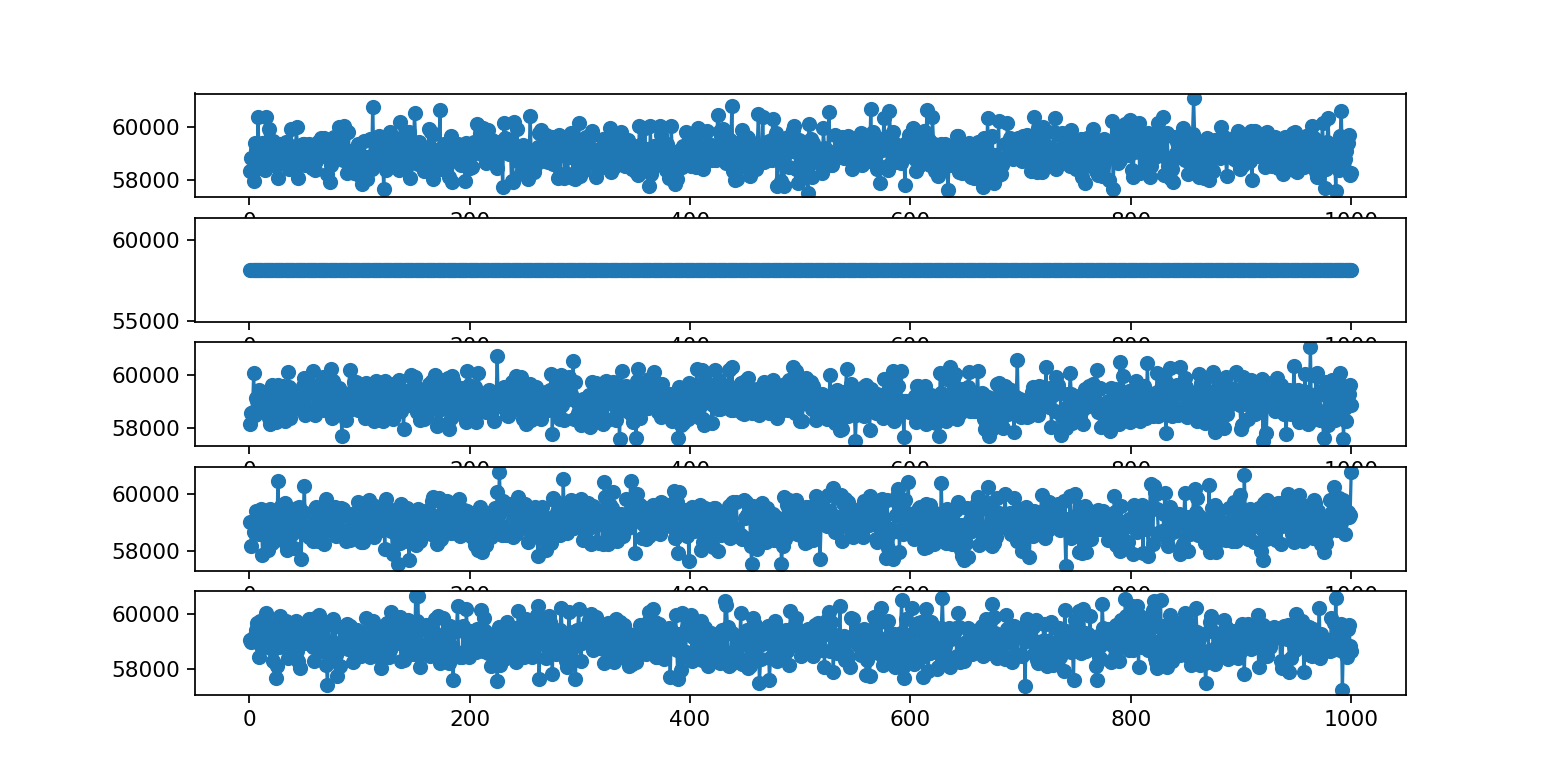

In [19]:
print('mersenne twister')
print(np.mean(res))
print(np.std(res))
print('unifrom grid')
print(np.mean(res1))
print(np.std(res1))
print('Xoroshiro128')
print(np.mean(res2))
print(np.std(res2))
print('PCG64')
print(np.mean(res3))
print(np.std(res3))
print('ThreeFry')
print(np.mean(res4))
print(np.std(res4))
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(5,1,figsize=(10, 5))
ax1.plot(xx1, res,'o-')
ax2.plot(xx1, res1,'o-')
ax3.plot(xx1, res2,'o-')
ax4.plot(xx1, res3,'o-')
ax5.plot(xx1, res4,'o-')

<IPython.core.display.Javascript object>


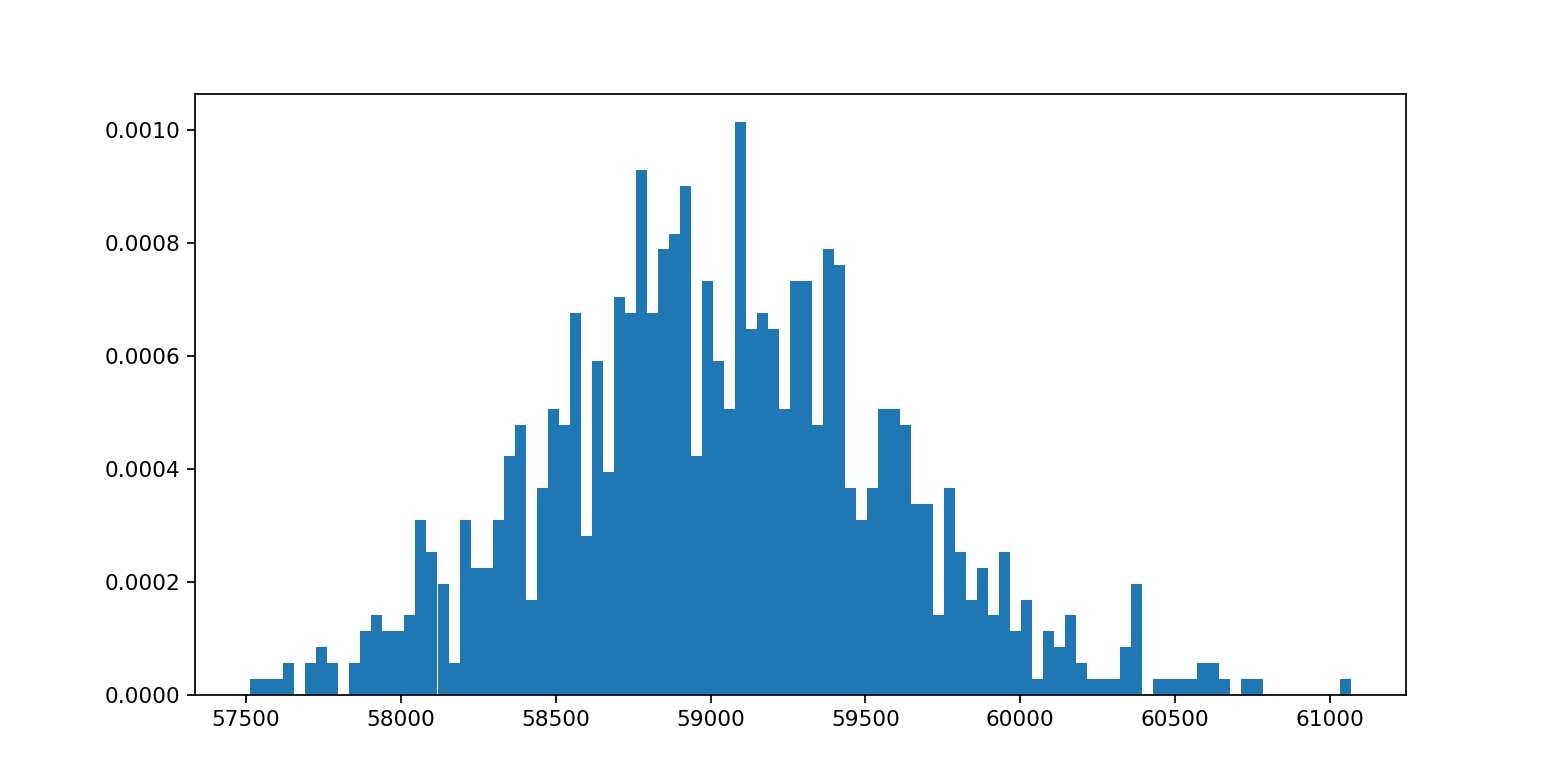

In [41]:
fig, ax1 = plt.subplots(1,1,figsize=(10, 5))
count, bins, ignored = ax1.hist(res, 100, density = True)

<IPython.core.display.Javascript object>


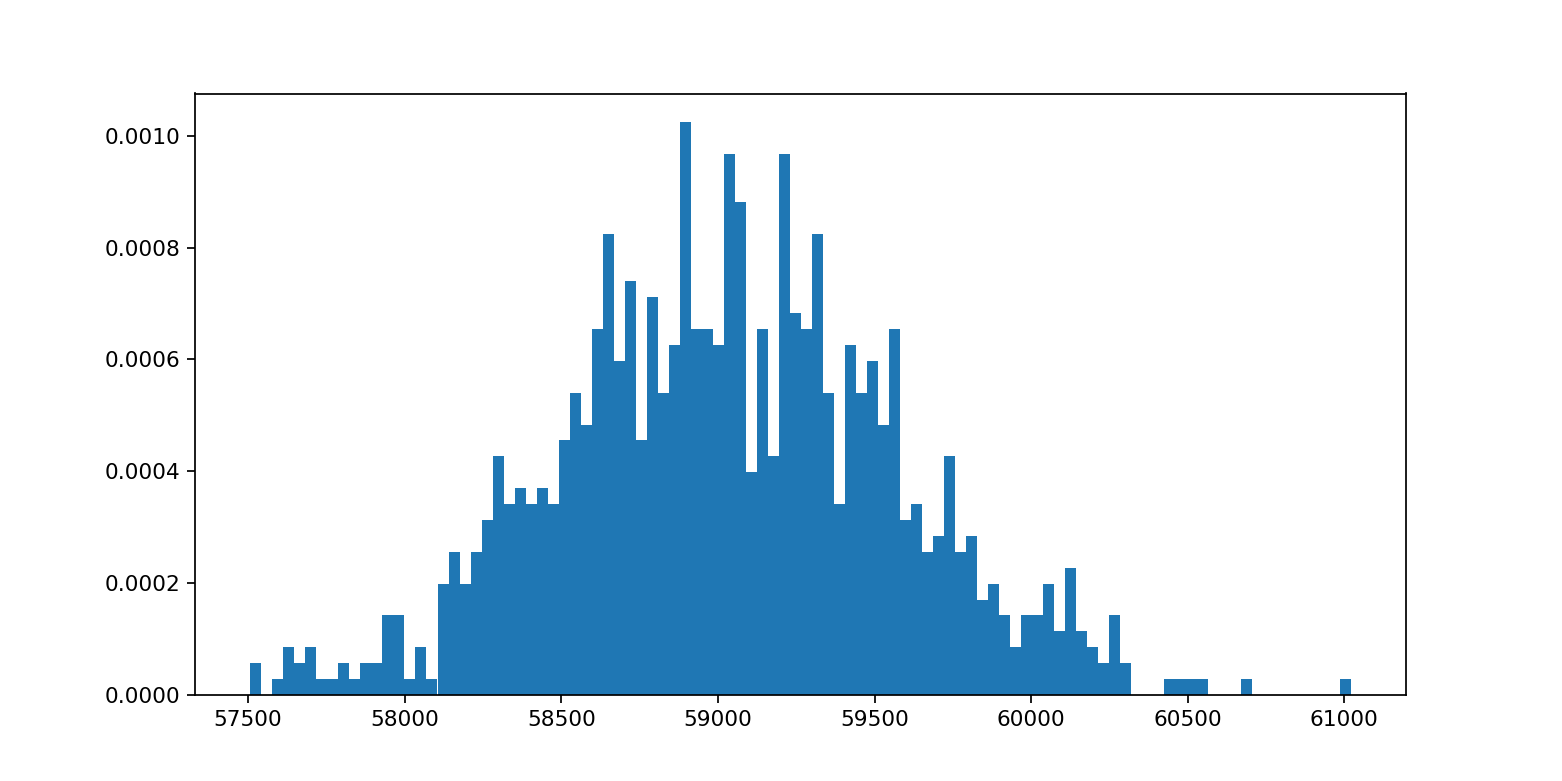

In [43]:
fig, ax1 = plt.subplots(1,1,figsize=(10, 5))
count, bins, ignored = ax1.hist(res2, 100, density = True)

<IPython.core.display.Javascript object>


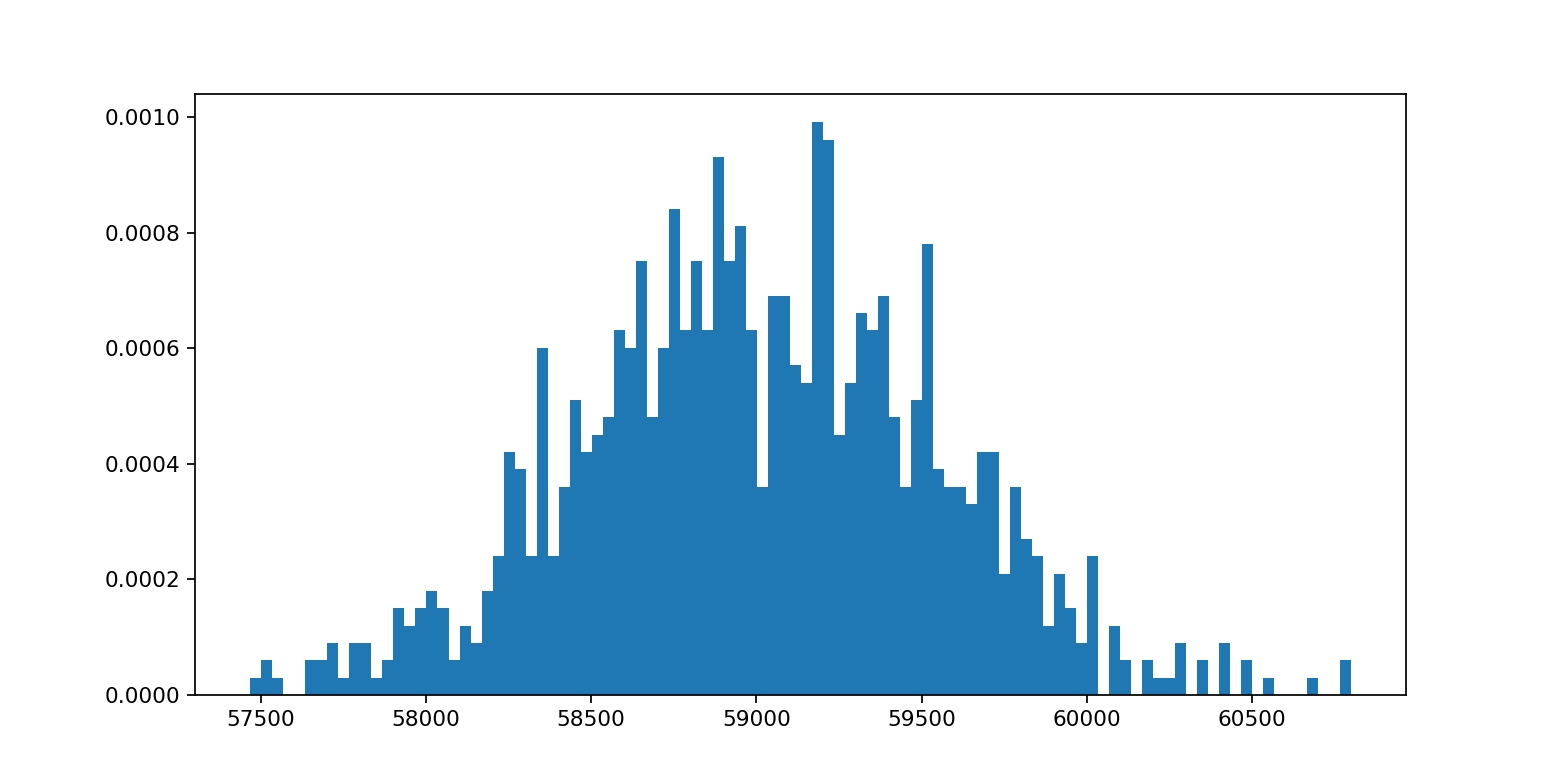

In [52]:
fig, ax1 = plt.subplots(1,1,figsize=(10, 5))
count, bins, ignored = ax1.hist(res3, 100, density = True)

<IPython.core.display.Javascript object>


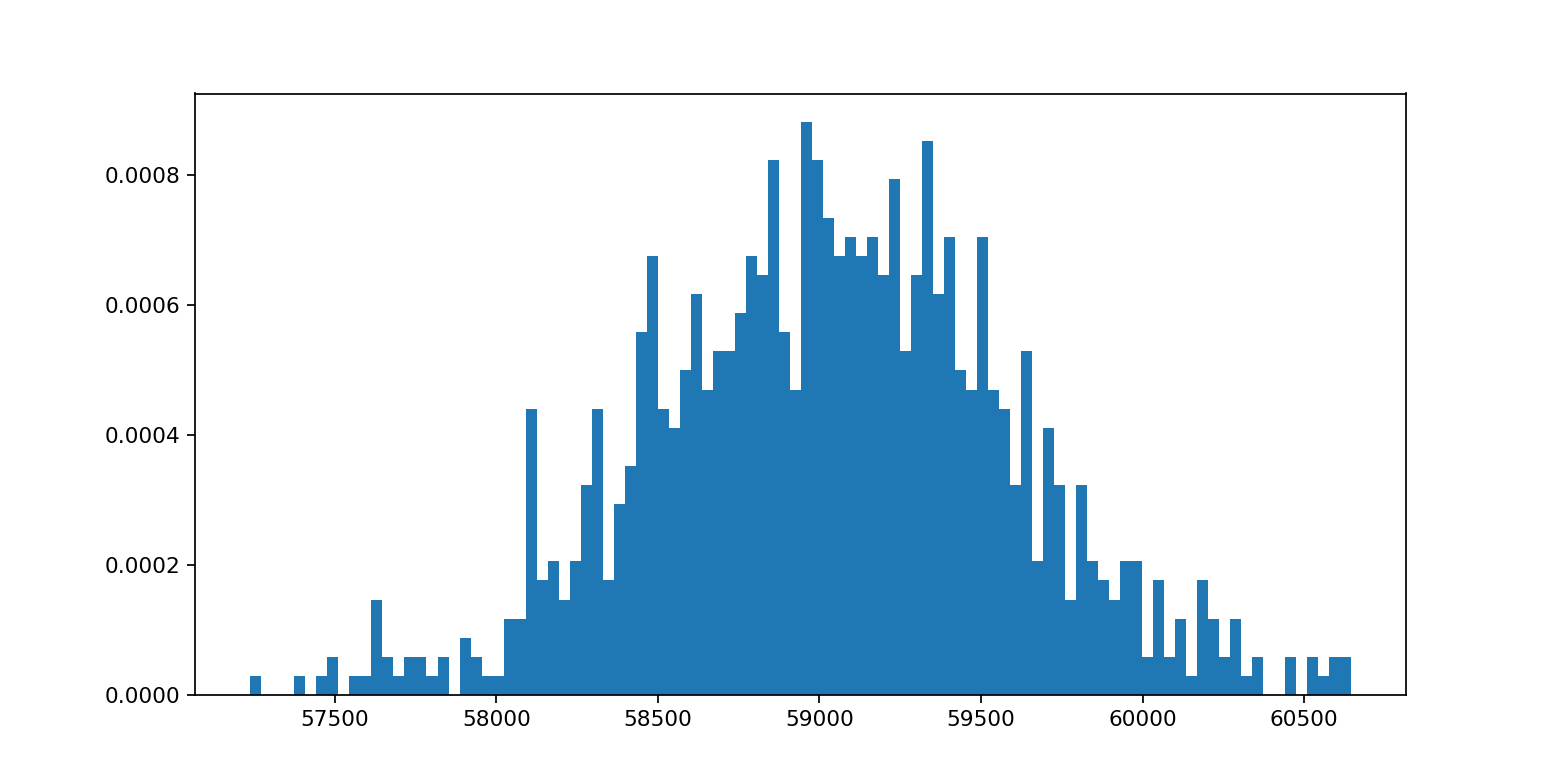

In [59]:
fig, ax1 = plt.subplots(1,1,figsize=(10, 5))
count, bins, ignored = ax1.hist(res4, 100, density = True)

In [88]:
interact(dextar_workspace, a=(1,100), b=(1,100), d=(1,60))

A Jupyter Widget

<function __main__.dextar_workspace>